# CNN-lytical Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28x28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32x32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [17]:
import torch
import numpy as np
import os,pickle
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
def set_seed(seed):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(0)

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1_IHICOfAsT7x63VBBuN1WMh4bDqtUThp/view?usp=sharing) shared for this assignment here.

In [18]:
# load the data set
pklData:dict = pickle.load(open('./train_cifar.pkl', 'rb'))
X = np.array(pklData['X'])
Y = np.array(pklData['y'])
X = torch.from_numpy(X).float()
X = X.permute(0,3,1,2)
Y = torch.from_numpy(Y).float()
# print(type(X))
valToScores = lambda val:np.vectorize(lambda x: 1 if x==val else 0)
aranged = np.arange(10)#[1,2,...,10]
scoreArray  =np.apply_along_axis(
    lambda y_elem:valToScores(y_elem)(aranged),
    1,
    Y
)
Y=torch.from_numpy(scoreArray).float()

print(X.shape,Y.shape)
k = 40000
X_train = X[:k]
Y_train = Y[:k]
X_test = X[k:]
Y_test = Y[k:]
print(X_test.shape,Y_test.shape,X_train.shape,Y_train.shape)
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library



torch.Size([50000, 3, 32, 32]) torch.Size([50000, 10])
torch.Size([10000, 3, 32, 32]) torch.Size([10000, 10]) torch.Size([40000, 3, 32, 32]) torch.Size([40000, 10])


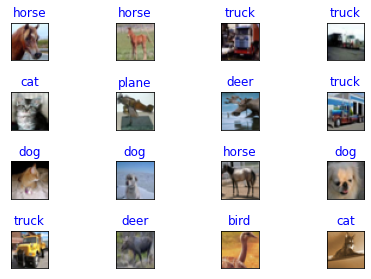

In [19]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
selection = np.random.choice(np.arange(X_train.shape[0]),size=16)
selImages = X_train[selection].permute(0,2,3,1).int()
selLabels = Y_train[selection].int().numpy()
fig,axs = plt.subplots(4,4)
fig.tight_layout()
from typing import List
# axs:List[plt.Axes]
# axs[0].imshow()
labels = [
    'plane',#0
    'car',#1
    'bird',#2
    'cat',#3
    'deer',#4
    'dog',#5
    'frog',#6
    'horse',#7
    'boat',#8
    'truck',#9    
]
for i in range(4):
    for j in range(4):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].imshow(selImages[4*i+j].reshape(32,32,3),cmap='gray',vmin=-1,vmax=1)
        axs[i,j].set_title(labels[int(selLabels[4*i+j].argsort()[-1])],color='blue')
plt.show()


## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [20]:
# define your dataset class
class Dataset:
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, i):
        if(i<len(self.Y)):
            return self.X[i],self.Y[i]
batchsize = 64
train_data = Dataset(X_train,Y_train)
test_data = Dataset(X_test,Y_test)
trainDataLoader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
testDataLoader = DataLoader(test_data,batch_size=batchsize,shuffle=True)




## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [21]:
# define a child class of nn.Module for your model
# specify the architecture here itself
F = torch.nn.functional
initDim = 32
outChannels = [32,64]
kernelSize = [5,5]
finalDim = int((((initDim - (kernelSize[0]-1))/2)-(kernelSize[1]-1))/2)
hls = [150,100]
numLabels = 10
class MaNet(torch.nn.Module):
    def __init__(self):
        super(MaNet,self).__init__()
        self.conv1 = torch.nn.Conv2d(3,outChannels[0],kernelSize[0])
        self.act1 = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2,2)
        self.conv2 = torch.nn.Conv2d(outChannels[0],outChannels[1],kernelSize[1])
        self.act2 = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(outChannels[1]*finalDim*finalDim,hls[0])
        self.fc2 = torch.nn.Linear(hls[0],hls[1])
        self.fc3 = torch.nn.Linear(hls[1],numLabels)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(f'shape1:{x.shape}')
        x = torch.flatten(x,1)
        # print(f'shape:{x.shape}')
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [22]:
def train(model:MaNet, optimizer:torch.optim.SGD, criterion, train_loader:DataLoader,epochs=100, display_step=None):
    for i in range(epochs):
        lossData = []
        for j,data in enumerate(train_loader,0):
            indata,target = data
            # print(indata,type(indata))
            optimizer.zero_grad()
            output = model(indata)
            loss = criterion(output,target)
            lossData.append(loss.item())
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if i%display_step==0:print(np.average(lossData))
    return lossData,model

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [23]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [24]:
def predict(model, X_test):
    output = model(X_test)
    return output

In [25]:
def accuracy(pred, labels):
    # print(labels,type(labels))
    labelsFlat = labels.numpy().argsort(axis=1)[:,-1].transpose()
    return np.round(100*np.where(
            labelsFlat
            ==
            pred.detach().numpy().argsort(axis=1)[:,-1]
            )[0].shape[0]/labelsFlat.shape[0])

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [27]:
model = MaNet()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
lossdata,newModel = train(model,optimizer,criterion,trainDataLoader,epochs=100,display_step=10)


1.8067691276550293
0.6737614827156067
0.2846834713339806
0.1605395585387945
0.12121641421988606
0.09119571139961481
0.0921198380637914
0.08230193737801164
0.0956450922082411
0.08761017388957552


In [ ]:
lossdata,newModel = train(newModel,optimizer,criterion,trainDataLoader,epochs=100,display_step=10)


In [ ]:
lossdata,newModel = train(newModel,optimizer,criterion,trainDataLoader,epochs=200,display_step=10)


In [ ]:
lossdata,newModel = train(newModel,optimizer,criterion,trainDataLoader,epochs=200,display_step=10)


In [ ]:
lossdata,newModel = train(newModel,optimizer,criterion,trainDataLoader,epochs=200,display_step=10)


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [30]:
i = 0
for j,data in enumerate(testDataLoader):
        testd,testlabs= data
        # print(testlabs.size(),type(testlabs))
        output = predict(newModel,testd)
        loss = torch.nn.MSELoss()(output,testlabs)
        acc = accuracy(output,testlabs)
        print(f"Loss on {j} test Data:{loss.item()}; Acc:{acc}")
        i+=1
        # if(i==10):break

Loss on 0 test Data:302.4514465332031; Acc:67.0
Loss on 1 test Data:351.2262268066406; Acc:56.0
Loss on 2 test Data:316.5968322753906; Acc:70.0
Loss on 3 test Data:382.83587646484375; Acc:61.0
Loss on 4 test Data:517.2520751953125; Acc:62.0
Loss on 5 test Data:182.09481811523438; Acc:56.0
Loss on 6 test Data:215.18984985351562; Acc:64.0
Loss on 7 test Data:363.46673583984375; Acc:70.0
Loss on 8 test Data:310.0190734863281; Acc:62.0
Loss on 9 test Data:264.2373962402344; Acc:67.0
Loss on 10 test Data:246.1958465576172; Acc:64.0
Loss on 11 test Data:401.13494873046875; Acc:73.0
Loss on 12 test Data:385.85076904296875; Acc:62.0
Loss on 13 test Data:352.0257263183594; Acc:67.0
Loss on 14 test Data:215.9383544921875; Acc:59.0
Loss on 15 test Data:360.6358337402344; Acc:67.0
Loss on 16 test Data:300.7040710449219; Acc:53.0
Loss on 17 test Data:498.34136962890625; Acc:70.0
Loss on 18 test Data:302.30633544921875; Acc:62.0
Loss on 19 test Data:275.22967529296875; Acc:62.0
Loss on 20 test Data:

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_2.pt``` model-weights file to the repository.

In [40]:
torch.save(newModel, 'ass_2.pt')


Check if it got saved right!

In [41]:
# load the model, use predict function
model = torch.load('ass_2.pt')
for data in testDataLoader:
    testB1,testL1 = data
    output = predict(newModel,testB1)
    acc = accuracy(output,testL1)
    print(acc)
    break

55.0
